# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

**File and Data Field Descriptions**

* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>
<br>

* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.<br>
<br>

* sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

## Summary

- Nesse trabalho foi utilizado 4 métodos de seleção de feature  e dois deles foram utilizados na modelagem. Notou-se que para alguns algoritmos não houve um grande impacto nos resultados, porém quando se utilizou os modelos de boost verificou-se uma melhora nos resultados quando utilizado o método de RFE.

- Para a modelagem foram testados os seguintes algoritmos de classificação:
    - KNN
    - Decision Tree
    - Regressão Logística
    - Naive-Bayes
    - SVM
    - Random Forest
    - AdaBoost
    - Gradient Boosting
    - XGBoost
    - LightGBM
    - CatBoost


- Os resultados de F1 score foram semelhantes, sendo que variáram, aproximadamente, entre 0,71 e 0,75.

- De forma geral, foi mais dificil determinar os passageiros que foram transportados (1).

- Os melhores modelos foram os de Random Forest, Gradient Boosting, XGBoost e LightGMB, em todos os casos utilizando o RFE. Esse foram os métodos que obtiveram F1 = ~ 0,754 e um maior acerto nos dados de positivos verdadeiros (1,1). Porém dentre eles o melhor modelo foi o XGBoost

- Nos dados de treino só havima dados de passageiros que não foram transportados (0,0 ou false). Para esse caso o modelo só consegui prever corretamebte ~60% dos dados.



# Importanto bibliotecas e dados

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report, plot_confusion_matrix,ConfusionMatrixDisplay
import graphviz


from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.feature_selection import f_classif, SelectKBest, RFECV, SequentialFeatureSelector
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Pandas backend loaded 1.3.5
Numpy backend loaded 1.21.0
Pyspark backend NOT loaded
Python backend loaded


In [2]:
# importanto os dados de treino
train = pd.read_csv('train.csv')

# Conhecendo os dados

In [16]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [18]:
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

Como froma de ter um panorama geral dos dados, foi utilziado o pandas profiling 

Nele é possivel verificar se há dados duplicados, nulos, etc.

In [39]:
profile = ProfileReport(train)
profile 

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


In [40]:
# salvando os relatórios no disco
#profile.to_file(output_file="Relatorio_data .html")

In [19]:
(train.isnull().sum()/len(train)*100).round(3)

PassengerId     0.000
HomePlanet      2.312
CryoSleep       2.496
Cabin           2.289
Destination     2.094
Age             2.059
VIP             2.335
RoomService     2.082
FoodCourt       2.105
ShoppingMall    2.393
Spa             2.105
VRDeck          2.163
Name            2.301
Transported     0.000
dtype: float64

Como a quantidade de dados nulos é meor que 3%,  irei retirar essas linhas 

In [4]:
train.dropna(inplace=True)

In [21]:
train.shape

(6606, 14)

Nota-se que a feature age está como flutuantes, porém deveria estar como inteiro

In [5]:
train["Age"] = train["Age"].astype('int64')

## Verificando a distribuição dos dados

Apesar do relatório dos dar uma visão geral dos dados é importante verificar como cada um deles estão distribuidos em relação a variável target, pois como isso é possível notar alguns problemas que podem ocorrer nos modelos.

**Transported**

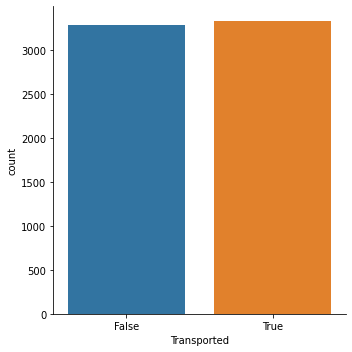

In [23]:
# verificando se os dados estão balanceados depois da limpeza dos dados
sns.catplot(data = train , x = "Transported", kind = "count");

**HomePlanet**

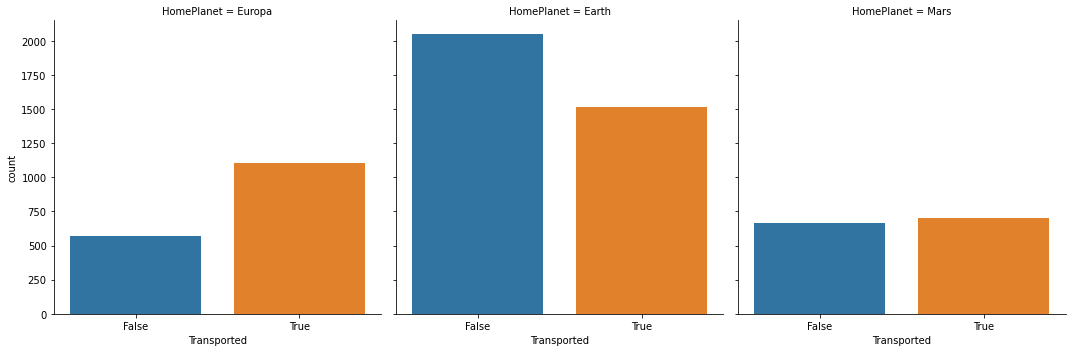

In [46]:
sns.catplot(data = train , x="Transported", kind = "count", col="HomePlanet");

**CryoSleep**

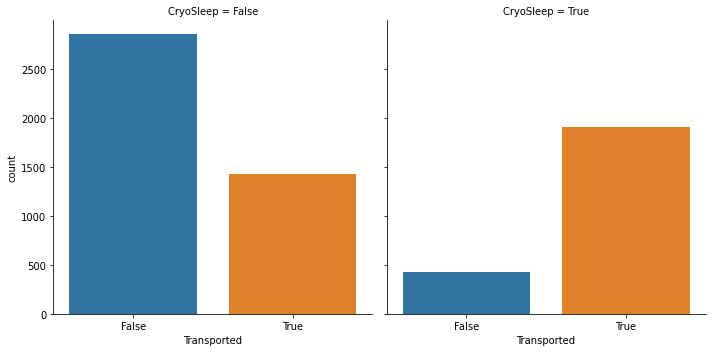

In [47]:
sns.catplot(data = train , x="Transported", kind = "count", col="CryoSleep");

**Destination**

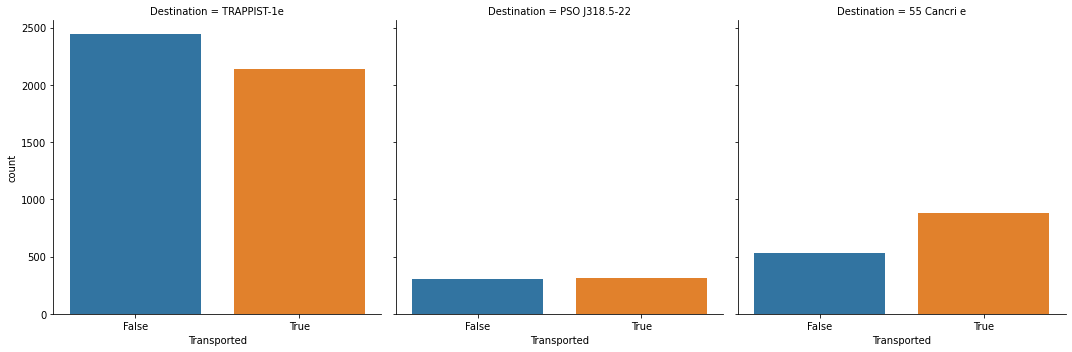

In [48]:
sns.catplot(data = train , x="Transported", kind = "count", col="Destination");

**Age**

In [49]:
px.histogram(train , x = "Age", color="Transported")

**VIP**

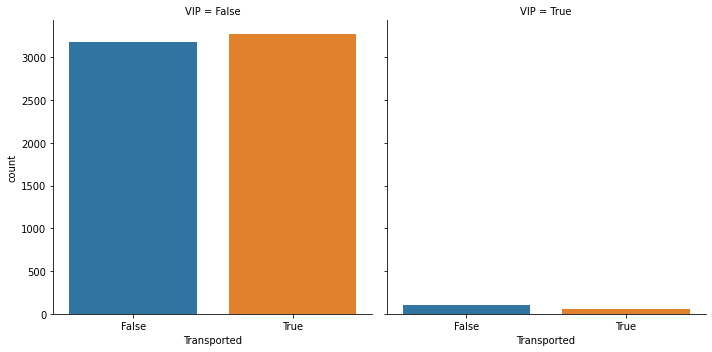

In [50]:
sns.catplot(data = train , x="Transported", kind = "count", col="VIP");

Como a maioria dos passageiros não eram VIPs, há uma grande chace dos modelos não conseguirem achar uma padrão entre os dados.

Como forma de remediar essa problema, será criada uma nova features, em função dos gastos dos passageiros na nave. Assim, como um isolamento colunas em relação à cabine que cada passageiro ficou.

**TotalBill**

In [6]:
train["TotalBill"] =  train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
px.histogram(train , x = "TotalBill", color="Transported")

**Cabin**

O valor em cada linha da coluna cabine é dividido em três partes: deck/num/side, sendo que o side pode ser:
- P for Port
- S for Starboard

Assim, essa coluna será divida em três e análisados o deck e side da feature.


In [7]:
train [['CabinDeck', 'CabinNum', 'CabinSide']]= train["Cabin"].str.split("/", expand=True)
train["CabinNum"] = train["CabinNum"].astype('int64')
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination  Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e   39  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e   24  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e   58   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e   33  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e   16  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  TotalBill CabinDeck  CabinNum CabinSide  
0        False        0.0         B         0         P  
1         True      736.0         F         0         S  
2        False    10383.0         A         0         S  
3        False     5176.0         A         0         S  
4         True     1091.0         F         1         S

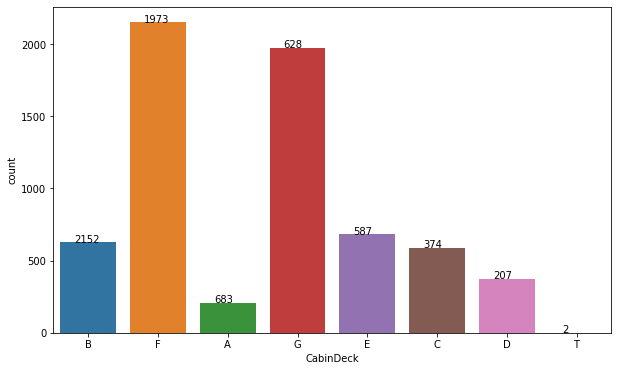

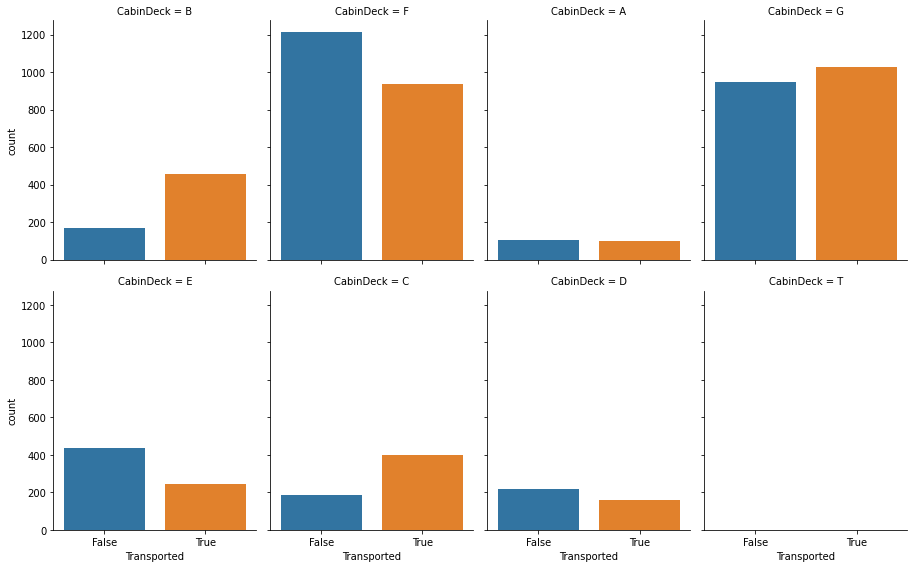

In [26]:
plt.figure(figsize=(10,6))

fig= sns.countplot(data=train, x=train["CabinDeck"])

for p, label in zip(fig.patches, train["CabinDeck"].value_counts()):  # para add os rótulos nas barras
    fig.annotate(label, (p.get_x()+0.2, p.get_height()+1))

sns.catplot(data=train, x="Transported", kind="count", col="CabinDeck", col_wrap=4, height=4, aspect=.8);

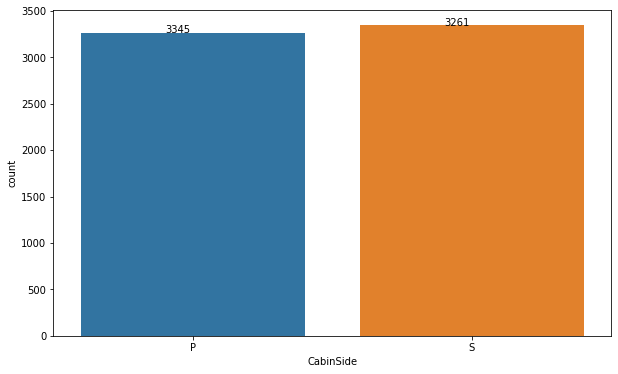

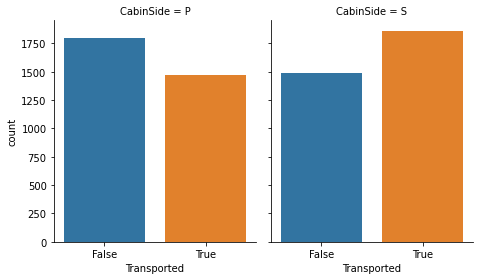

In [27]:
plt.figure(figsize=(10,6))

fig= sns.countplot(data=train, x=train["CabinSide"])

for p, label in zip(fig.patches, train["CabinSide"].value_counts()):  # para add os rótulos nas barras
    fig.annotate(label, (p.get_x()+0.3, p.get_height()+1))

sns.catplot(data=train, x="Transported", kind="count", col="CabinSide", col_wrap=4, height=4, aspect=.8);

**PassengerId**

Cada Id tem o formato `gggg_pp` onde `gggg` indica um grupo com o qual o passageiro está viajando e `pp` é seu número dentro do grupo. .

Cada linha da coluna PassengerId é dividido em duas partes:
- gggg: indica um grupo com o qual o passageiro está viajando
- pp: é seu número dentro do grupo

As pessoas em um grupo geralmente são membros da família, mas nem sempre

Assim, essa coluna será divida em duas partes e análisado os grupos em relação ao target


In [8]:
train [['IdGroup', 'IdNumber']]= train["PassengerId"].str.split("_", expand=True)
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination  Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e   39  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e   24  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e   58   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e   33  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e   16  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  TotalBill CabinDeck  CabinNum CabinSide IdGroup IdNumber  
0        False        0.0         B         0         P    0001       01  
1         True      736.0         F         0         S    0002       01  
2        False    10383.0         A         0         S    0003       01  
3        False     5176.0         A         0         S    0003       02  
4         True     1091.0         F         1         S    0004       01

In [30]:
train["IdGroup"].unique()

array(['0001', '0002', '0003', ..., '9278', '9279', '9280'], dtype=object)

In [33]:
train["IdGroup"].value_counts()

4256    8
9157    7
3850    7
4498    7
4176    7
       ..
3504    1
3506    1
3511    1
3512    1
4634    1
Name: IdGroup, Length: 5015, dtype: int64

In [9]:
train["IdGroup"] = train["IdGroup"].astype('int64')

In [45]:
px.histogram(train , x = "IdGroup", color = "Transported")

Pelas análises é possivel observar que algumas features estão bem balanceadas, e em outras, a maior parte de dados é de passageiros que foram tranportados. 

# Modelagem

## Tratando os dados 

Para a modelagem dos dados é necessário  fazer alguns tratamentos, como a criação de colunas dummys para os dados categórigos 

In [10]:
# criando as colunas dummy para as variáveis categóricas
colunas = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'CabinDeck', 'CabinSide']
train = pd.get_dummies(train, columns = colunas, drop_first=True)

In [11]:
# escolhendo a semente para garantir a reproducibilidade dos resultados
SEED = 42
np.random.seed(SEED)

In [12]:
# separando os dados de treino em X e y
X_train = train.drop(['PassengerId','IdNumber', 'Cabin','RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported_True'], axis=1)

y_train =  train['Transported_True']

## Seleção de feauture

Existem diversas formas e métodos de se realizar a seleção de features, sendo uma delas a adição no pipeline  do modelo. Porém, como o intuito desse projeto é aprender como realizar as diversas etapas de um projeto de ML, irei fazer a seleção em separado para compreender como alguns métodos funcionam .
Para tal, testarei 4  métodos de seleção de features e comprar elas, para então fazer a retiradas das features.Para isso serão utilzados os métodos:

- Filter: SelectKBest(f_classif), Feature Importance(random forest)
- Wrappen: SequentialFeatureSelector (random forest) e RFE (random forest)


**SelectKBest**


In [23]:
SB = SelectKBest(score_func=f_classif, k=10) 
SB.fit(X_train,y_train)
features = SB.transform(X_train)
print(" Colunas Selecionadas: ", SB.get_feature_names_out(input_features=None))

 Colunas Selecionadas:  ['Age' 'TotalBill' 'HomePlanet_Europa' 'CryoSleep_True'
 'Destination_TRAPPIST-1e' 'CabinDeck_B' 'CabinDeck_C' 'CabinDeck_E'
 'CabinDeck_F' 'CabinSide_S']


**Feature Importance**

In [41]:
FI = RandomForestClassifier(n_estimators=10, random_state=SEED)
FI.fit(X_train, y_train)
print(FI.feature_importances_)

[1.59792847e-01 2.76980001e-01 1.83066118e-01 1.78469282e-01
 2.01317298e-02 1.07486072e-02 6.31196529e-02 6.80033051e-03
 1.86728946e-02 4.19985222e-03 5.50129245e-03 6.00860039e-03
 3.87616834e-03 1.15396622e-02 1.40020972e-02 1.35346571e-02
 9.24326073e-05 2.34637743e-02]


In [42]:
feature_importances = pd.DataFrame(FI.feature_importances_, index= X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

importance
TotalBill                  0.276980
CabinNum                   0.183066
IdGroup                    0.178469
Age                        0.159793
CryoSleep_True             0.063120
CabinSide_S                0.023464
HomePlanet_Europa          0.020132
Destination_TRAPPIST-1e    0.018673
CabinDeck_F                0.014002
CabinDeck_G                0.013535

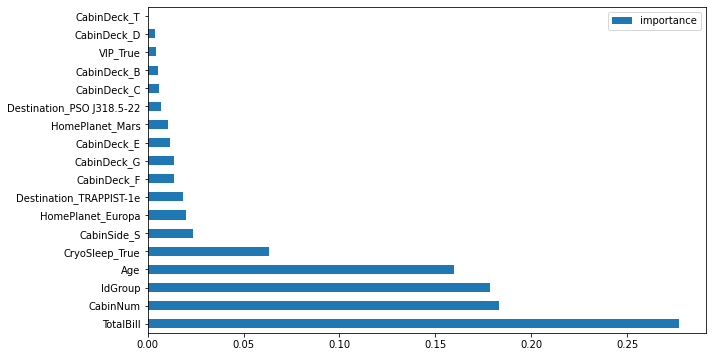

In [61]:
feature_importances.plot(kind='barh', figsize=(10,6));

**SequentialFeatureSelector**

In [49]:
SFS = RandomForestClassifier(n_estimators= 10, random_state= SEED)
cv = KFold(n_splits=10, shuffle=True)

feature_selector = SequentialFeatureSelector(SFS, 
                                             n_features_to_select = 10,
                                             direction = 'backward',
                                             scoring = 'f1',
                                             cv = cv)

feature_selector.fit(X_train, y_train)

print("nome das colunas", feature_selector.get_feature_names_out(input_features=None))                                            

nome das colunas ['TotalBill' 'HomePlanet_Europa' 'HomePlanet_Mars' 'CryoSleep_True'
 'VIP_True' 'CabinDeck_B' 'CabinDeck_C' 'CabinDeck_D' 'CabinDeck_E'
 'CabinSide_S']


**RFE**

In [18]:
rfe = RandomForestClassifier(n_estimators= 10, random_state= SEED)
cv = KFold(n_splits=10, shuffle=True)


rfe_selector = RFECV(rfe, 
                     min_features_to_select = 5,
                     step = 1,
                     scoring = 'f1',
                     cv = cv)

rfe_selector.fit(X_train, y_train)

print("nome das colunas", rfe_selector.get_feature_names_out(input_features=None))

nome das colunas ['Age' 'TotalBill' 'CabinNum' 'IdGroup' 'HomePlanet_Europa'
 'HomePlanet_Mars' 'CryoSleep_True' 'Destination_PSO J318.5-22'
 'Destination_TRAPPIST-1e' 'VIP_True' 'CabinDeck_B' 'CabinDeck_C'
 'CabinDeck_D' 'CabinDeck_E' 'CabinDeck_F' 'CabinDeck_G' 'CabinSide_S']


**Comparando os resultados**


In [50]:
print("**SelectKBest\n", SB.get_feature_names_out(input_features=None))
print("**SequentialFeatureSelector\n", feature_selector.get_feature_names_out(input_features=None))
print("**RFECV\n", rfe_selector.get_feature_names_out(input_features=None))
print("**Feature importances\n", feature_importances.index[0:10])

**SelectKBest
 ['Age' 'TotalBill' 'HomePlanet_Europa' 'CryoSleep_True'
 'Destination_TRAPPIST-1e' 'CabinDeck_B' 'CabinDeck_C' 'CabinDeck_E'
 'CabinDeck_F' 'CabinSide_S']
**SequentialFeatureSelector
 ['TotalBill' 'HomePlanet_Europa' 'HomePlanet_Mars' 'CryoSleep_True'
 'VIP_True' 'CabinDeck_B' 'CabinDeck_C' 'CabinDeck_D' 'CabinDeck_E'
 'CabinSide_S']
**RFECV
 ['Age' 'TotalBill' 'CabinNum' 'IdGroup' 'HomePlanet_Europa'
 'HomePlanet_Mars' 'CryoSleep_True' 'Destination_PSO J318.5-22'
 'Destination_TRAPPIST-1e' 'VIP_True' 'CabinDeck_B' 'CabinDeck_C'
 'CabinDeck_D' 'CabinDeck_E' 'CabinDeck_F' 'CabinDeck_G' 'CabinSide_S']
**Feature importances
 Index(['TotalBill', 'CabinNum', 'IdGroup', 'Age', 'CryoSleep_True',
       'CabinSide_S', 'HomePlanet_Europa', 'Destination_TRAPPIST-1e',
       'CabinDeck_F', 'CabinDeck_G'],
      dtype='object')


In [13]:
features_selected_SB = ['Age', 'TotalBill', 'HomePlanet_Europa', 'CryoSleep_True','Destination_TRAPPIST-1e',
                        'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_F', 'CabinSide_S']

features_selected_SFS= ['TotalBill', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_True', 'VIP_True', 
                        'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinSide_S']

features_selected_RFE = ['Age', 'TotalBill', 'CabinNum', 'IdGroup', 'HomePlanet_Europa', 'HomePlanet_Mars',
                         'CryoSleep_True','Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_True',
                         'CabinDeck_B', 'CabinDeck_C','CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 
                         'CabinDeck_G', 'CabinSide_S']

features_selected_FI = ['TotalBill', 'CabinNum', 'IdGroup', 'Age', 'CryoSleep_True','CabinSide_S', 
                        'HomePlanet_Europa', 'Destination_TRAPPIST-1e','CabinDeck_F', 'CabinDeck_G']

Primeiramente vale resaltar que os métodos SequentialFeatureSelector e RFECV  a cada vez que são executados, retornam features diferentes. Fato esse que confirmei ao ler algumas matérias sobre o tema, pois varios  reclamam  desse problema. Segundo relatos isso ocorre pois  as features de menor importância acabam mudando.

Sendo assim, rodei algumas vezes os modelos e comparei os resultados obtidos. Ao verificar que o modelo tinha escolhidos as features mais comuns para cada um deles, armazenei os resulatdos em uma lista.


De forma geral, nota-se que algumas diferenças entre cada um dos métodos utilizados, sendo que segundo o  RFE, quase todas as features são importantes.

Para compreender melhor como que cada método trabalha, é possivel fazer uma comparação entre os resultados obtidos. 

* Colunas em comum entre os 4 métodos são:
    - Age
    - TotalBill
    - HomePlanet_Europa
    - CryoSleep_True
    - CabinSide_S
    - Destination_TRAPPIST-1e
<br><br>

* Colunas em comum entre 3 dos 4 métodos são:
    - HomePlanet_Mars
    - CabinDeck_C
    - CabinDeck_E
    - CabinDeck_G
    - CabinDeck_F
    - CabinNum


Nota-se que somente 6 das 10 features solicitadas são iguais entre os 4 métodos e que mais 6 entre 3 dos 4 metodos.
Ao comprar as features acima com cada um dos metodos, nota-se que o métodos SequentialFeatureSelector foi o que teve menos features das escolhidas, bem como foi o que teve maiores mudança a cada vez que o código foi executad. Já o RFE possui features que não foi ecolhida por nenhum dos outros métodos, como "Destination_PSO J318.5-22".

Se fosse para escolher somente um dos métodos acredito que tanto o SelectKBest quanto o Feature importances seriam bons, visto que ambos retornam o mesmo valor a cada execução. 

Porém como critério de análise, nesse trabalho, serão realizados dois modelos para cada algorítmo, um usando as features escolhidas pelo SelectKBest e outro com as do RFECV, pois esse métodos propos que quase todas as features são importantes. Sendo assim a ideia é verificar se realmente haverá uma grande diferença entre os modelos utilizando mais ou menos features.


In [14]:
X_train_SB= X_train[features_selected_SB]
X_train_RFE= X_train[features_selected_RFE]

In [53]:
X_train_SB.head()

Age  TotalBill  HomePlanet_Europa  CryoSleep_True  Destination_TRAPPIST-1e  \
0   39        0.0                  1               0                        1   
1   24      736.0                  0               0                        1   
2   58    10383.0                  1               0                        1   
3   33     5176.0                  1               0                        1   
4   16     1091.0                  0               0                        1   

   CabinDeck_B  CabinDeck_C  CabinDeck_E  CabinDeck_F  CabinSide_S  
0            1            0            0            0            0  
1            0            0            0            1            1  
2            0            0            0            0            1  
3            0            0            0            0            1  
4            0            0            0            1            1

In [54]:
X_train_RFE.head()

Age  TotalBill CabinNum IdGroup  HomePlanet_Europa  HomePlanet_Mars  \
0   39        0.0        0    0001                  1                0   
1   24      736.0        0    0002                  0                0   
2   58    10383.0        0    0003                  1                0   
3   33     5176.0        0    0003                  1                0   
4   16     1091.0        1    0004                  0                0   

   CryoSleep_True  Destination_PSO J318.5-22  Destination_TRAPPIST-1e  \
0               0                          0                        1   
1               0                          0                        1   
2               0                          0                        1   
3               0                          0                        1   
4               0                          0                        1   

   VIP_True  CabinDeck_B  CabinDeck_C  CabinDeck_D  CabinDeck_E  CabinDeck_F  \
0         0            1            0            0            0            0   
1         0            0            0            0            0            1   
2         1            0            0            0            0            0   
3         0            0            0            0            0            0   
4         0            0            0            0            0            1   

   CabinDeck_G  CabinSide_S  
0            0            0  
1            0            1  
2            0            1  
3            0            1  
4            0            1

## Métricas de avalição de modelo

In [15]:
# Criando um dicionário com as métricas a serem utilizadas 
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='macro'),
                 'recall': make_scorer(recall_score, average='macro'),
                 'f1': make_scorer(f1_score, average='macro'),
                 'rocAUC': make_scorer(roc_auc_score, average='macro')
                 }

# Criando uma função para calcular e imprimir as métricas escolhidas
def metricas(grid):
    
    idx = grid.best_index_
   
    acc_mean = grid.cv_results_['mean_test_accuracy'][idx]  
    acc_std= grid.cv_results_['std_test_accuracy'][idx]
     
    
    print ("Acurácia: ", acc_mean.round(4))
    print("Intervalo da acurácia: [%.2f, %.2f]" % ((acc_mean - 2 * acc_std)*100, (acc_mean + 2 * acc_std) * 100))

    print (" ")

    print ("Precision: ", grid.cv_results_['mean_test_precision'][idx].round(4))
    print ("Recall: ", grid.cv_results_['mean_test_recall'][idx].round(4))
    print ("F1 Score: ", grid.cv_results_['mean_test_f1'][idx].round(4))
    print ("AUROC: ", grid.cv_results_['mean_test_rocAUC'][idx].round(4))

## KNN

In [59]:
# Definindo os parâmetros do cross validation 
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# criando o pipeline
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('model', KNeighborsClassifier())])


# hyper-parameters are specified as <step name>__<hyper-parameter name>
param_gridKNN = {"model__n_neighbors": list(range(1, 30, 1)),
              "model__weights": ['uniform', 'distance'],
              "model__p": [1, 2, 3, 4, 5],
              "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}


# instanciando o RandomizedSearch
gridKNN = RandomizedSearchCV(pipe_knn,
                    param_gridKNN,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)

**SelectKBest**

In [60]:
gridKNN.fit(X_train_SB, y_train)

print("best:", gridKNN.best_params_)
print("score:", gridKNN.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridKNN)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 29, 'model__algorithm': 'kd_tree'}
score: 0.7417493018661927
 
Acurácia:  0.7439
Intervalo da acurácia: [71.57, 77.20]
 
Precision:  0.7536
Recall:  0.7446
F1 Score:  0.7417
AUROC:  0.7446


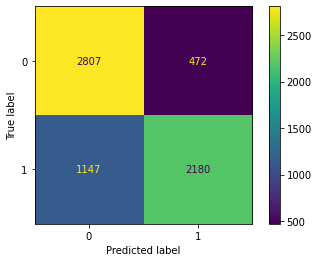

In [61]:
plot_confusion_matrix(gridKNN,X_train_SB, y_train,values_format='d' );

**RFECV**

In [62]:
gridKNN.fit(X_train_RFE, y_train)

print("best:", gridKNN.best_params_)
print("score:", gridKNN.best_score_)
print(" ")

# imprimindo os resultados
metricas (gridKNN)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 29, 'model__algorithm': 'kd_tree'}
score: 0.749456306542837
 
Acurácia:  0.7511
Intervalo da acurácia: [71.89, 78.34]
 
Precision:  0.7594
Recall:  0.7518
F1 Score:  0.7495
AUROC:  0.7518


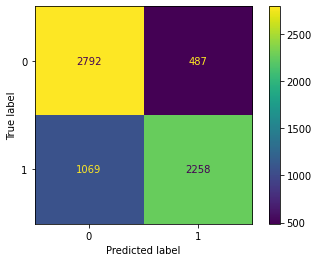

In [63]:
plot_confusion_matrix(gridKNN, X_train_RFE, y_train,values_format='d' );

- Para ambos os modelos os melhores parâmetros foram os mesmo, independete das features escolhidas
- SelectKBest foi melhor para prever valores falsos 
- RFE foi melhor para prever valores verdadeiros
- F1 socre semelhante entre os modelos  

## Decision Tree

In [30]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# definindo o algoritimo 
model_DT= DecisionTreeClassifier(random_state=SEED)

# grid parâmetros
param_gridDT = {'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': range(1,10),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'min_samples_split': range(1,10),
                'min_samples_leaf':range(1,10)}    


# instanciando o RandomizedSearch
gridDT = RandomizedSearchCV(model_DT,
                    param_gridDT,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)

**SelectKBest**

In [32]:
gridDT.fit(X_train_SB, y_train)

print("best:", gridDT.best_params_)
print("score:", gridDT.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridDT)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'gini'}
score: 0.7402701276527157
 
Acurácia:  0.7417
Intervalo da acurácia: [71.23, 77.12]
 
Precision:  0.7485
Recall:  0.7423
F1 Score:  0.7403
AUROC:  0.7423


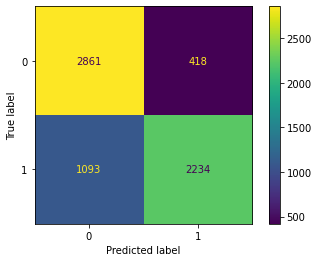

In [33]:
plot_confusion_matrix(gridDT,X_train_SB, y_train,values_format='d' );

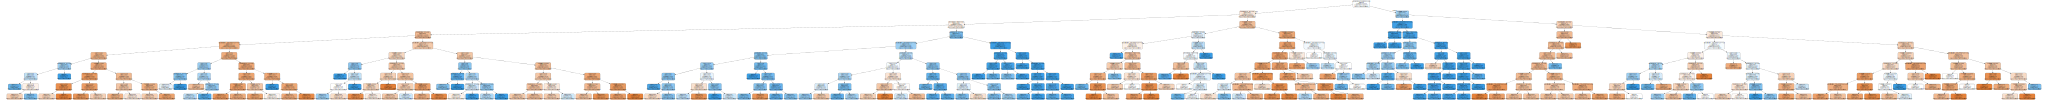

In [34]:
features = X_train_SB.columns
dot_data = export_graphviz(gridDT.best_estimator_, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["Não Transportado", "Transportado"])
grafico = graphviz.Source(dot_data)
grafico

**RFECV**

In [35]:
gridDT.fit(X_train_RFE, y_train)

print("best:", gridDT.best_params_)
print("score:", gridDT.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridDT)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 7, 'criterion': 'gini'}
score: 0.7407418611665566
 
Acurácia:  0.743
Intervalo da acurácia: [71.55, 77.04]
 
Precision:  0.7529
Recall:  0.7436
F1 Score:  0.7407
AUROC:  0.7436


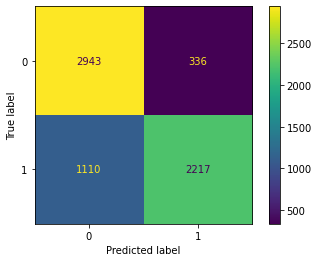

In [36]:
plot_confusion_matrix(gridDT,X_train_RFE, y_train,values_format='d' );

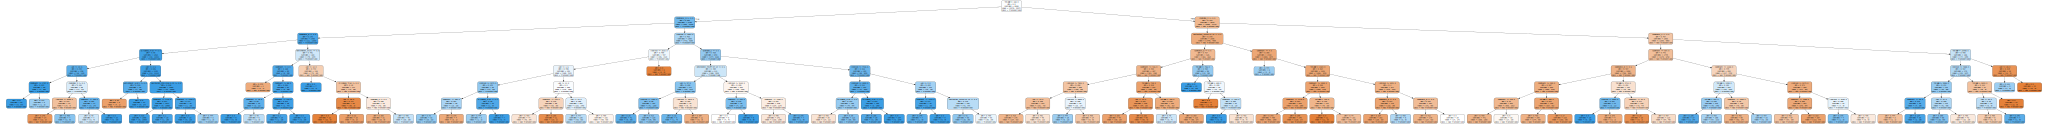

In [37]:
features = X_train_RFE.columns
dot_data = export_graphviz(gridDT.best_estimator_, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["Não Transportado", "Transportado"])
grafico = graphviz.Source(dot_data)
grafico

- Nota-se pequenas diferenaças nos melhores parâmetros
- SelectKBest foi melhor para prever valores vedadeiros 
- RFE foi melhor para prever valores falsos
- F1 socre semelhante entre os modelos  


## Regreção Logística

In [24]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_RL = LogisticRegression(random_state=SEED)


# grid parâmetros
param_gridRL = {'penalty': ['l1','l2', 'elasticnet'], 
              'C': [0.001,0.01,0.1,1,10,100,1000],
              'class_weight': ['dic', 'balanced', None],
              'max_iter': [100,1000,10000]}
                 
# instanciando o RandomizedSearch
gridRL = RandomizedSearchCV(model_RL,
                    param_gridRL,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [25]:
gridRL.fit(X_train_SB, y_train)

print("best:", gridRL.best_params_)
print("score:", gridRL.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRL)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'penalty': 'l2', 'max_iter': 10000, 'class_weight': 'balanced', 'C': 0.001}
score: 0.730013029917981
 
Acurácia:  0.7315
Intervalo da acurácia: [70.23, 76.06]
 
Precision:  0.7377
Recall:  0.732
F1 Score:  0.73
AUROC:  0.732


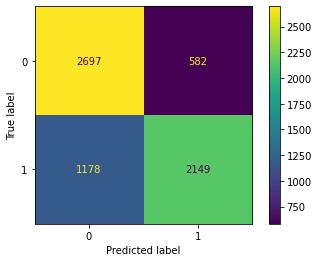

In [26]:
plot_confusion_matrix(gridRL,X_train_SB, y_train,values_format='d' );

**RFECV**

In [73]:
gridRL.fit(X_train_RFE, y_train)

print("best:", gridRL.best_params_)
print("score:", gridRL.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRL)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'penalty': 'l2', 'max_iter': 1000, 'class_weight': None, 'C': 0.1}
score: 0.7257053838374756
 
Acurácia:  0.7269
Intervalo da acurácia: [68.86, 76.52]
 
Precision:  0.7319
Recall:  0.7274
F1 Score:  0.7257
AUROC:  0.7274


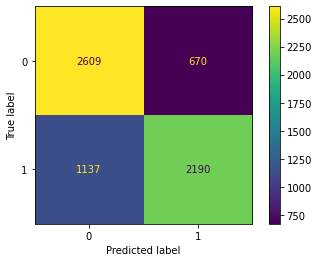

In [74]:
plot_confusion_matrix(gridRL,X_train_RFE, y_train,values_format='d' );

- nota-se 50% dos parâmetros são iguais
- SelectKBest foi melhor para prever valores falsos
- RFE foi melhor para prever valores verdadeiros
- F1 socre semelhante entre os modelos  

## Naive-Bayes

In [76]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_NB = GaussianNB()


# grid parâmetros
param_gridNB = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}
                 
# instanciando o RandomizedSearch
gridNB = RandomizedSearchCV(model_NB,
                    param_gridNB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [77]:
gridNB.fit(X_train_SB, y_train)

print("best:", gridNB.best_params_)
print("score:", gridNB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridNB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'var_smoothing': 1e-10}
score: 0.7143352164141625
 
Acurácia:  0.7157
Intervalo da acurácia: [68.27, 74.87]
 
Precision:  0.7208
Recall:  0.7162
F1 Score:  0.7143
AUROC:  0.7162


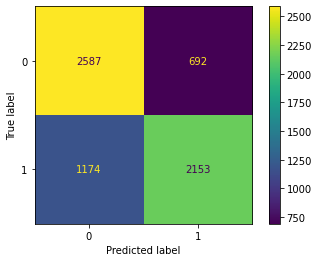

In [78]:
plot_confusion_matrix(gridNB,X_train_SB, y_train,values_format='d' );

**RFECV**

In [79]:
gridNB.fit(X_train_RFE, y_train)

print("best:", gridNB.best_params_)
print("score:", gridNB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridNB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'var_smoothing': 1e-10}
score: 0.7107511778849899
 
Acurácia:  0.7121
Intervalo da acurácia: [67.94, 74.48]
 
Precision:  0.7169
Recall:  0.7126
F1 Score:  0.7108
AUROC:  0.7126


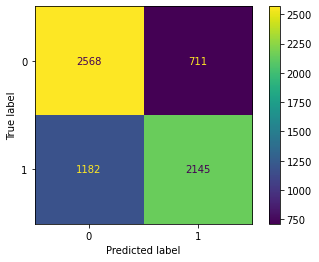

In [80]:
plot_confusion_matrix(gridNB,X_train_RFE, y_train,values_format='d' );

- SelectKBest foi melhor para prever valores verdadeiros e falsos
 

## SVM

In [81]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
pipe_SVC = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC(random_state=SEED))])


# grid parâmetros
param_gridSVM = {'model__C': [0.001,0.01,0.1,1,10,100,1000],
                 'model__kernel': ['rbf', 'poly', 'sigmoid', 'precomputed'],
                 'model__degree': [1,2,3,4,5,6,7,8,9,10, ],
                 'model__gamma': ['auto', 'scale'],
                 'model__class_weight': ['dict','balanced', None],
                 'model__max_iter': [100,1000,10000]}

                 
# instanciando o RandomizedSearch
gridSVM = RandomizedSearchCV(pipe_SVC,
                    param_gridSVM,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [86]:
gridSVM.fit(X_train_SB, y_train)

print("best:", gridSVM.best_params_)
print("score:", gridSVM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridSVM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__max_iter': 10000, 'model__kernel': 'poly', 'model__gamma': 'auto', 'model__degree': 1, 'model__class_weight': 'balanced', 'model__C': 0.1}
score: 0.7140730598635223
 
Acurácia:  0.7201
Intervalo da acurácia: [69.08, 74.94]
 
Precision:  0.7425
Recall:  0.7212
F1 Score:  0.7141
AUROC:  0.7212


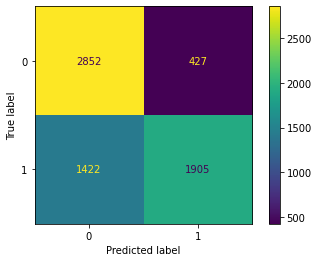

In [83]:
plot_confusion_matrix(gridSVM,X_train_SB, y_train,values_format='d' );

**RFECV**

In [87]:
gridSVM.fit(X_train_RFE, y_train)

print("best:", gridSVM.best_params_)
print("score:", gridSVM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridSVM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__max_iter': 10000, 'model__kernel': 'poly', 'model__gamma': 'auto', 'model__degree': 1, 'model__class_weight': 'balanced', 'model__C': 0.1}
score: 0.7140730598635223
 
Acurácia:  0.7201
Intervalo da acurácia: [69.08, 74.94]
 
Precision:  0.7425
Recall:  0.7212
F1 Score:  0.7141
AUROC:  0.7212


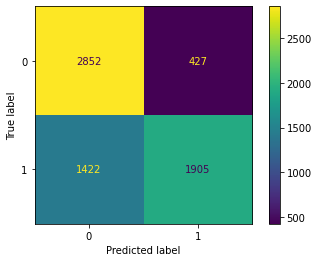

In [88]:
plot_confusion_matrix(gridSVM,X_train_RFE, y_train,values_format='d' );

Para o SVC independete das features o resultado é o mesmo 
 

## Random Forest

In [60]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_RF = RandomForestClassifier()


# grid parâmetros
param_gridRF = {'criterion': ['gini', 'entropy'],
                'max_depth': range(1,10),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'min_samples_split': range(1,10),
                'min_samples_leaf':range(1,10),
                'n_estimators': [10,100,1000,10000]} 

                 
# instanciando o RandomizedSearch
gridRF = RandomizedSearchCV(model_RF,
                    param_gridRF,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [97]:
gridRF.fit(X_train_SB, y_train)

print("best:", gridRF.best_params_)
print("score:", gridRF.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRF)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy'}
score: 0.7499921339212402
 
Acurácia:  0.7516
Intervalo da acurácia: [72.83, 77.49]
 
Precision:  0.7595
Recall:  0.7522
F1 Score:  0.75
AUROC:  0.7522


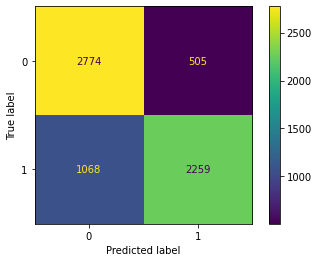

In [98]:
plot_confusion_matrix(gridRF,X_train_SB, y_train,values_format='d' );

**RFECV**

In [61]:
gridRF.fit(X_train_RFE, y_train)

print("best:", gridRF.best_params_)
print("score:", gridRF.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRF)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}
score: 0.7542790371891374
 
Acurácia:  0.7561
Intervalo da acurácia: [72.13, 79.10]
 
Precision:  0.7654
Recall:  0.7568
F1 Score:  0.7543
AUROC:  0.7568


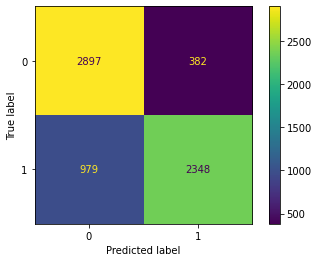

In [62]:
plot_confusion_matrix(gridRF,X_train_RFE, y_train,values_format='d' );

- Melhor modelo até o momento
- RFE teve os melhores resultados 
- F1 semelhante
 

## AdaBoost

In [111]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_AB = AdaBoostClassifier()

# grid parâmetros
param_gridAB = {'learning_rate': [0.001,0.01,0.1,1,10,100,1000],
                'n_estimators': [1, 10, 20, 30,100,1000,10000],
                'algorithm': ['SAMME', 'SAMME.R']}

                
                 
# instanciando o RandomizedSearch
gridAB = RandomizedSearchCV(model_AB,
                    param_gridAB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [108]:
gridAB.fit(X_train_SB, y_train)

print("best:", gridAB.best_params_)
print("score:", gridAB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridAB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
score: 0.7338228528876567
 
Acurácia:  0.7346
Intervalo da acurácia: [70.35, 76.57]
 
Precision:  0.7383
Recall:  0.735
F1 Score:  0.7338
AUROC:  0.735


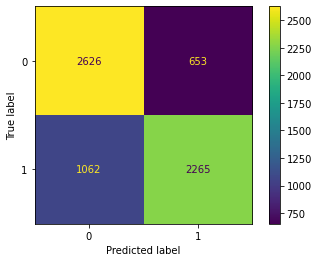

In [109]:
plot_confusion_matrix(gridAB,X_train_SB, y_train,values_format='d' );

**RFECV**

In [112]:
gridAB.fit(X_train_RFE, y_train)

print("best:", gridAB.best_params_)
print("score:", gridAB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridAB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
score: 0.736695895646671
 
Acurácia:  0.7372
Intervalo da acurácia: [70.20, 77.24]
 
Precision:  0.7397
Recall:  0.7375
F1 Score:  0.7367
AUROC:  0.7375


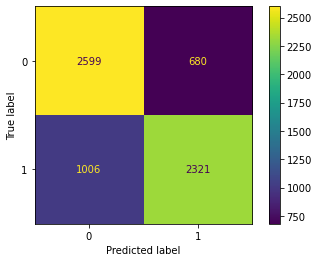

In [113]:
plot_confusion_matrix(gridAB,X_train_RFE, y_train,values_format='d' );

- RFE melhor para valores verdadeiros
- SelectKBest melhor para valores falsos 
- F1 semelhante
 

## Gradiente Boosting

In [63]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_GB = GradientBoostingClassifier()

# grid parâmetros
param_gridGB = {'loss':['deviance', 'exponential'],
                'learning_rate': [0.001,0.01,0.1,1,10,100,1000],
                'n_estimators': [10,100,1000,10000],
                'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],              
                'min_samples_split': range(1,10),
                'min_samples_leaf':range(1,10),
                'max_depth': range(1,10),
                'max_features': ['auto', 'sqrt', 'log2', None]}

                 
# instanciando o RandomizedSearch
gridGB = RandomizedSearchCV(model_GB,
                    param_gridGB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [117]:
gridGB.fit(X_train_SB, y_train)

print("best:", gridGB.best_params_)
print("score:", gridGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.9, 'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 9, 'loss': 'deviance', 'learning_rate': 0.001}
score: 0.7442355341464847
 
Acurácia:  0.7464
Intervalo da acurácia: [71.82, 77.46]
 
Precision:  0.7568
Recall:  0.7471
F1 Score:  0.7442
AUROC:  0.7471


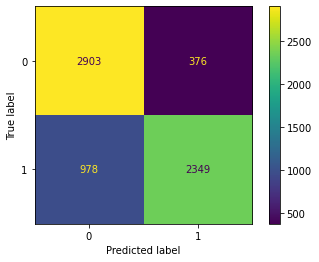

In [118]:
plot_confusion_matrix(gridGB,X_train_SB, y_train,values_format='d' );

**RFECV**

In [64]:
gridGB.fit(X_train_RFE, y_train)

print("best:", gridGB.best_params_)
print("score:", gridGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.9, 'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 9, 'loss': 'deviance', 'learning_rate': 0.001}
score: 0.7554131818741476
 
Acurácia:  0.7569
Intervalo da acurácia: [71.72, 79.66]
 
Precision:  0.7644
Recall:  0.7575
F1 Score:  0.7554
AUROC:  0.7575


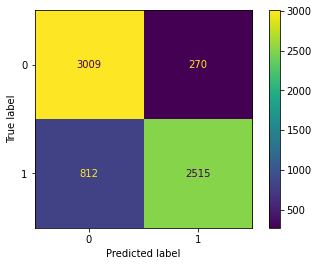

In [65]:
plot_confusion_matrix(gridGB,X_train_RFE, y_train,values_format='d' );

- RFE foi melhor que SelectKBest.
- Melhor modelo que o Random Forest ( até então tinha sido o melhor)
 

## XGBoost

In [43]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_XGB = XGBClassifier()


# grid parâmetros
param_gridXGB = {'min_child_weight': [1, 5, 10],
                 'gamma': [0.5, 1, 1.5, 2, 5],
                 'subsample': [0.6, 0.8, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0],
                 'max_depth':range(1,10),
                 'eta': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                 'n_estimators': [10,100,1000,10000],
                 'scale_pos_weight': [1, 5, 10]}

# Métricas retiradas por conta da demora no treino
#'booster': ['gbtree', 'gblinear', 'dart'],
#'tree_method': ['exact', 'approx', 'hist', 'gpu_hist']
                
# instanciando o RandomizedSearch
gridXGB = RandomizedSearchCV(model_XGB,
                    param_gridXGB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [44]:
gridXGB.fit(X_train_SB, y_train)

print("best:", gridXGB.best_params_)
print("score:", gridXGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridXGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[00:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.1, 'colsample_bytree': 1.0}
score: 0.7419598096155675
 
Acurácia:  0.7437
Intervalo da acurácia: [71.76, 76.98]
 
Precision:  0.7519
Recall:  0.7443
F1 Score:  0.742
AUROC:  0.7443


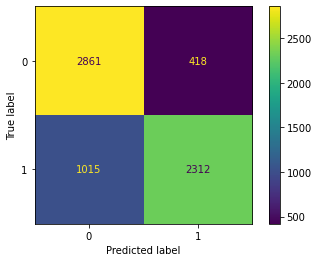

In [45]:
plot_confusion_matrix(gridXGB,X_train_SB, y_train,values_format='d' );

**RFECV**

In [46]:
gridXGB.fit(X_train_RFE, y_train)

print("best:", gridXGB.best_params_)
print("score:", gridXGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridXGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[00:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.1, 'colsample_bytree': 1.0}
score: 0.7531257877451343
 
Acurácia:  0.7545
Intervalo da acurácia: [72.23, 78.66]
 
Precision:  0.7612
Recall:  0.755
F1 Score:  0.7531
AUROC:  0.755


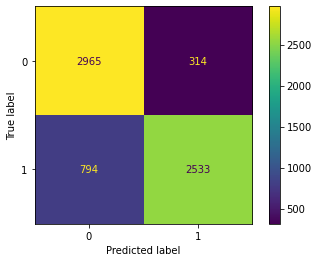

In [47]:
plot_confusion_matrix(gridXGB,X_train_RFE, y_train,values_format='d' );

- RFE gerou os melhores resultados
- Melhor modelo para prever passageiros transportados

## LightGBM

In [21]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_LGBM = lgb.LGBMClassifier()


# grid parâmetros
param_gridLGBM = {'learning_rate': [0.005, 0.01],
                  'n_estimators': [100, 1000, 10000],
                  'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
                  'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
                  'objective' : ['binary'],
                  'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
                  'colsample_bytree' : [0.64, 0.65, 0.66],
                  'subsample' : [0.7, 0.8, 0.9],
                  'reg_alpha' : [1,1.2],
                  'reg_lambda' : [1,1.2,1.4]}

                 
# instanciando o RandomizedSearch
gridLGBM = RandomizedSearchCV(model_LGBM,
                    param_gridLGBM,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [22]:
gridLGBM.fit(X_train_SB, y_train)

print("best:", gridLGBM.best_params_)
print("score:", gridLGBM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridLGBM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.8, 'reg_lambda': 1.2, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 1000, 'max_bin': 255, 'learning_rate': 0.005, 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
score: 0.746560620467729
 
Acurácia:  0.7486
Intervalo da acurácia: [71.61, 78.10]
 
Precision:  0.758
Recall:  0.7492
F1 Score:  0.7466
AUROC:  0.7492


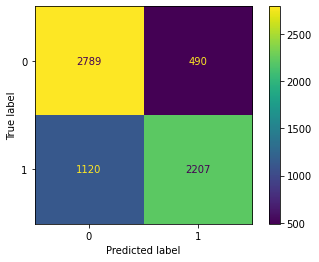

In [23]:
plot_confusion_matrix(gridLGBM,X_train_SB, y_train,values_format='d' );

**RFECV**

In [24]:
gridLGBM.fit(X_train_RFE, y_train)

print("best:", gridLGBM.best_params_)
print("score:", gridLGBM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridLGBM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 6, 'n_estimators': 10000, 'max_bin': 255, 'learning_rate': 0.01, 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
score: 0.7565378404074616
 
Acurácia:  0.7581
Intervalo da acurácia: [72.66, 78.96]
 
Precision:  0.7661
Recall:  0.7587
F1 Score:  0.7565
AUROC:  0.7587


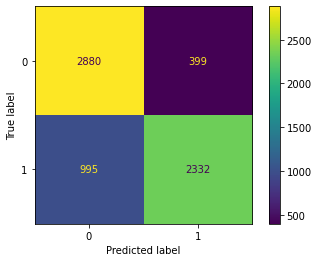

In [58]:
plot_confusion_matrix(gridLGBM,X_train_RFE, y_train,values_format='d' );

RFE teve os melhores resultados
 

## CatBoost

In [16]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_CB = CatBoostClassifier()


# grid parâmetros
param_gridCB = {'n_estimators': [100, 1000, 10000],
                'max_depth': range(1,10),
                'learning_rate': range(0,3),
                'l2_leaf_reg': range(1,10)}

                 
# instanciando o RandomizedSearch
gridCB = RandomizedSearchCV(model_CB,
                    param_gridCB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**SelectKBest**

In [17]:
gridCB.fit(X_train_SB, y_train)

print("best:", gridCB.best_params_)
print("score:", gridCB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridCB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0:	learn: 0.5663156	total: 136ms	remaining: 2m 15s
1:	learn: 0.5514896	total: 141ms	remaining: 1m 10s
2:	learn: 0.5307828	total: 145ms	remaining: 48.2s
3:	learn: 0.5262291	total: 148ms	remaining: 37s
4:	learn: 0.5163446	total: 152ms	remaining: 30.2s
5:	learn: 0.5155451	total: 155ms	remaining: 25.7s
6:	learn: 0.5119487	total: 162ms	remaining: 22.9s
7:	learn: 0.5108400	total: 166ms	remaining: 20.6s
8:	learn: 0.5089179	total: 169ms	remaining: 18.6s
9:	learn: 0.5082247	total: 173ms	remaining: 17.1s
10:	learn: 0.5071262	total: 177ms	remaining: 15.9s
11:	learn: 0.5061519	total: 182ms	remaining: 15s
12:	learn: 0.5055720	total: 189ms	remaining: 14.4s
13:	learn: 0.5051292	total: 193ms	remaining: 13.6s
14:	learn: 0.5046991	total: 197ms	remaining: 12.9s
15:	learn: 0.5041326	total: 201ms	remaining: 12.4s
16:	learn: 0.5031850	total: 204ms	remaining: 11.8s
17:	learn: 0.5026412	total: 211ms	remaining: 11.5s
18:	learn: 0.5014129	total: 214

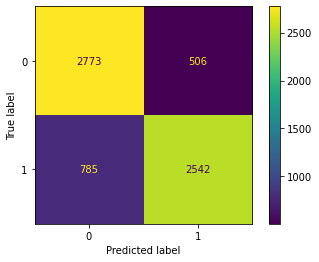

In [18]:
plot_confusion_matrix(gridCB,X_train_SB, y_train,values_format='d' );

**RFECV**

In [19]:
gridCB.fit(X_train_RFE, y_train)

print("best:", gridCB.best_params_)
print("score:", gridCB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridCB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0:	learn: 0.5740754	total: 9.43ms	remaining: 1m 34s
1:	learn: 0.5593170	total: 12.2ms	remaining: 1m
2:	learn: 0.5536860	total: 16.6ms	remaining: 55.3s
3:	learn: 0.5479334	total: 19.9ms	remaining: 49.6s
4:	learn: 0.5468195	total: 22.9ms	remaining: 45.7s
5:	learn: 0.5438446	total: 32.1ms	remaining: 53.4s
6:	learn: 0.5418498	total: 36.6ms	remaining: 52.2s
7:	learn: 0.5400493	total: 43.1ms	remaining: 53.8s
8:	learn: 0.5374088	total: 46.5ms	remaining: 51.6s
9:	learn: 0.5356897	total: 53.5ms	remaining: 53.5s
10:	learn: 0.5348654	total: 56.8ms	remaining: 51.6s
11:	learn: 0.5334991	total: 59.9ms	remaining: 49.8s
12:	learn: 0.5321247	total: 70.6ms	remaining: 54.3s
13:	learn: 0.5309258	total: 73ms	remaining: 52s
14:	learn: 0.5295645	total: 76.7ms	remaining: 51.1s
15:	learn: 0.5285256	total: 79.3ms	remaining: 49.5s
16:	learn: 0.5276832	total: 81.9ms	remaining: 48.1s
17:	learn: 0.5270069	total: 86.6ms	remaining: 48s
18:	learn: 0.526448

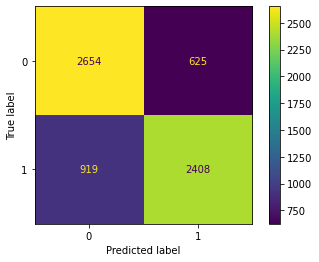

In [20]:
plot_confusion_matrix(gridCB,X_train_RFE, y_train,values_format='d' );

RFE teve os melhores resultados
 

## Qual foi o melhor modelo?

Os melhores modelos foram os de Random Forest, Gradiente Boosting, XGBoost e LightGMB, em todos os casos utilizando o RFE. Esse foram os métodos que obtiveram F1 = ~ 0,754 e um maior acerto nos dados.   

Porém dentre eles  o que teve maior acerto de:
- Passageiros transportados -> Gradiente Boosting
- Passageiros não transportados -> XGBoost


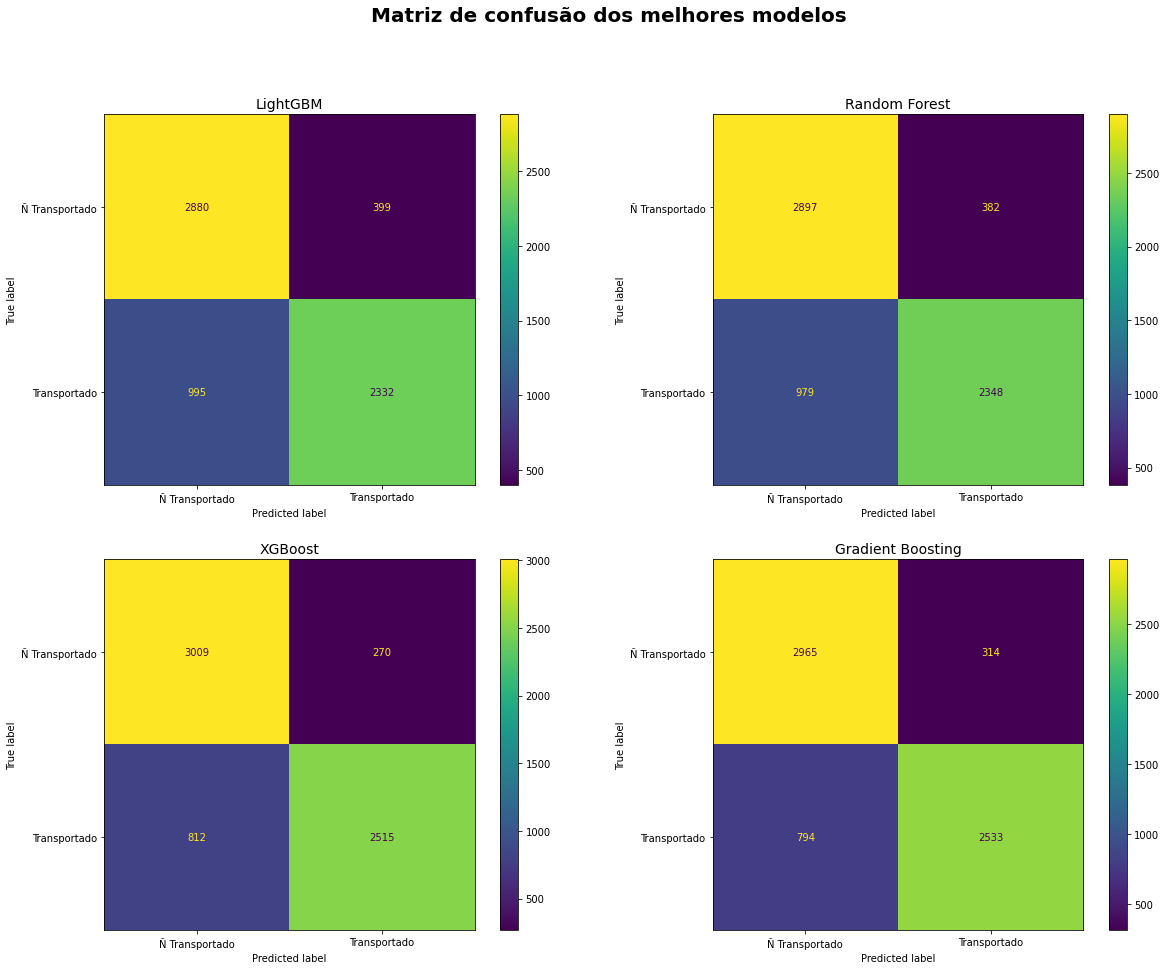

In [109]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
plt.suptitle('Matriz de confusão dos melhores modelos', fontsize=20, fontweight='bold')

#lightGBM
g1= ConfusionMatrixDisplay.from_estimator(gridLGBM,X_train_RFE, y_train, ax = ax[0,0],display_labels=['Ñ Transportado','Transportado'])
g1.ax_.set_title('LightGBM',fontsize=14)


#random forest
g2 = ConfusionMatrixDisplay.from_estimator(gridRF,X_train_RFE, y_train, ax = ax[0,1], display_labels=['Ñ Transportado','Transportado'])
g2.ax_.set_title('Random Forest',fontsize=14)


#XGBoost
g3= ConfusionMatrixDisplay.from_estimator(gridGB,X_train_RFE, y_train, ax = ax[1,0], display_labels=['Ñ Transportado','Transportado'])
g3.ax_.set_title('XGBoost',fontsize=14)


#gradiente boosting
g4 =ConfusionMatrixDisplay.from_estimator(gridXGB,X_train_RFE, y_train, ax = ax[1,1],display_labels=['Ñ Transportado','Transportado'])
g4.ax_.set_title('Gradient Boosting',fontsize=14)

plt.show()
 

Ao comprar os resultados obtidos para os modelos de Gradiente Boosting e XGBoost, nota-se que a diferença entre a quantidade de acertos de passageiros transpotados é de apenas 14. E a difrença entre os valores de precision e recall são de 0,0032 e 0,0025 respectivamente.

Então, o critério utilizado foi escolher o que o modelo que teve um maior certo de passageiros não transportados, que no caso é o modelo gerado pelo algoritmo XGBooster.

 # Testanto o modelo 


In [40]:
# importanto os dados de teste
xtest = pd.read_csv('test.csv')
ytest = pd.read_csv('sample_submission.csv')

In [41]:
# unindo os arquivos test para a limpeza dos dados
test = pd.merge(xtest, ytest, how = 'inner', on = 'PassengerId')

In [42]:
test.head(3)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0          0.0        0.0           0.0     0.0     0.0  Nelly Carsoning   
1          0.0        9.0           0.0  2823.0     0.0   Lerome Peckers   
2          0.0        0.0           0.0     0.0     0.0  Sabih Unhearfus   

   Transported  
0        False  
1        False  
2        False

In [43]:
# retitando os dados nulos
test.dropna(inplace=True)

In [44]:
# Criando a coluna TotalBill
test["TotalBill"] =  test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [45]:
test[['CabinDeck', 'CabinNum', 'CabinSide']]= test["Cabin"].str.split("/", expand=True)
test [['IdGroup', 'IdNumber']]= test["PassengerId"].str.split("_", expand=True)

In [46]:
test["Age"] = test["Age"].astype('int64')
test["CabinNum"] = test["CabinNum"].astype('int64')
test["IdGroup"] = test["IdGroup"].astype('int64')

In [47]:
# Fazendo o get.dummy das colunas categoricas
# OBS: Ao colucar a coluna Transported ela desaparace do dataset, pois só há uma categoria nos dados de teste selecionados pelo Kaggle
colunas = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']
test = pd.get_dummies(test, columns = colunas, drop_first=True)

In [48]:
# separando os dados de teste em X e y
# features escolhidas são as mesmas escolhidas no treino, pelo método RFECV
X_test_RFE= test[features_selected_RFE]

y_test = test['Transported']

In [31]:
# treinando o modelo nos dados de teste

model = XGBClassifier (subsample = 1.0, 
                       scale_pos_weight =1,
                       n_estimators= 100,
                       min_child_weight = 10, 
                       max_depth = 9, 
                       gamma =0.5,
                       eta= 0.1,
                       colsample_bytree = 1.0,
                       random_state=SEED,
                       verbose=2, n_jobs=2)
    

model.fit(X_train_RFE, y_train)
y_pred = model.predict(X_test_RFE)
print(classification_report(y_test, y_pred))

[21:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:55:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.57      0.72      3281
           1       0.00      0.00      0.00         0

    accuracy                           0.57      3281
   macro avg       0.50      0.28      0.36      3281
we

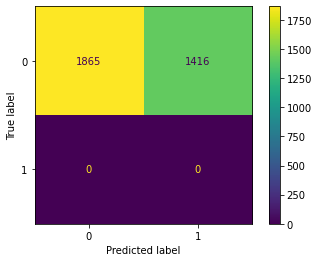

In [32]:
plot_confusion_matrix(model,X_test_RFE, y_test,values_format='d' );

- Os resultados no dados de teste não foram tão satisfatórios.
- Só haviam dados de pessoas que não haviam sido tranportadas (0,0). 
- Basicamente o modelo só pode prever metade de dados corretamente.


## SHAP

In [33]:
explainer_tree = shap.Explainer(model.predict, X_test_RFE)
shap_values_tree = explainer_tree(X_test_RFE)

Permutation explainer: 3282it [22:40,  2.41it/s]                          


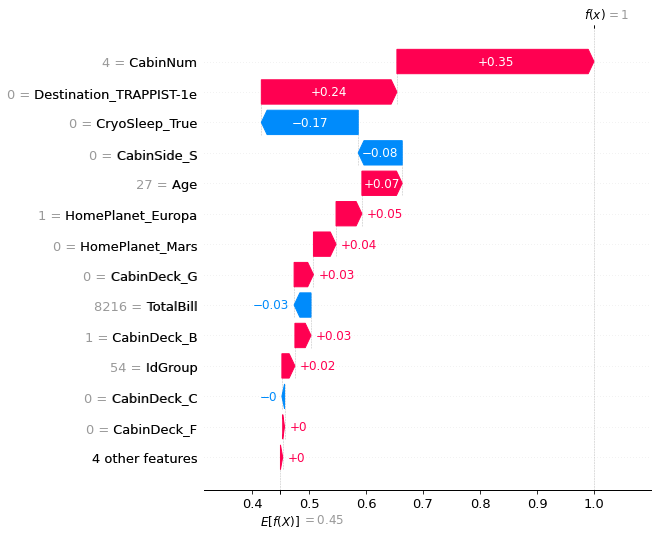

In [34]:
sample_ind=17
shap.plots.waterfall(shap_values_tree[sample_ind], max_display=14)

O gráfico SHAP mostra os recursos que contribuem com o modelo, a partir de uma valor base(a média de todas as observações).

No  gráfico estilo "waterfall", a visualização inicia-se de baixo para cima, sendo, onde os valores em verlho são adicionados ao valor base e os azuis são subtraidos, até chegar à previsão final.

Por padrão, o SHAP explica os modelos de classificadores XGBoost em termos de saída de margem, antes da função de link logístico. 

Isso significa que as unidades no eixo x são unidades de probabilidades logarítmicas, portanto, valores negativos implicam em probabilidades inferiores a 0,5 de que a pessoa tenha sido tranportada. 

Com isso podemos verificar que tanto o número da cabine quanto o destino são fatores que aumentam o previsão. Já no caso da criogênia e o lado da cabine  diminuiem o valor da previsão.

# Treinando o modelo com todos os  dados

In [105]:
train = X_train_RFE.join(y_train)
train.rename(columns={'Transported_True': 'Transported'}, inplace=True)

In [106]:
teste = X_test_RFE.join(y_test)

In [107]:
dados = pd.concat([train, teste], ignore_index=True)
dados.head(3)

Age  TotalBill  CabinNum  IdGroup  HomePlanet_Europa  HomePlanet_Mars  \
0   39        0.0         0        1                  1                0   
1   24      736.0         0        2                  0                0   
2   58    10383.0         0        3                  1                0   

   CryoSleep_True  Destination_PSO J318.5-22  Destination_TRAPPIST-1e  \
0               0                          0                        1   
1               0                          0                        1   
2               0                          0                        1   

   VIP_True  CabinDeck_B  CabinDeck_C  CabinDeck_D  CabinDeck_E  CabinDeck_F  \
0         0            1            0            0            0            0   
1         0            0            0            0            0            1   
2         1            0            0            0            0            0   

   CabinDeck_G  CabinSide_S  Transported  
0            0            0            0  
1            0            1            1  
2            0            1            0

In [108]:
dados.shape

(9887, 18)

In [109]:
X = dados.drop(['Transported'], axis=1)
y = dados['Transported']

In [110]:
model = XGBClassifier (subsample = 1.0, 
                       scale_pos_weight =1,
                       n_estimators= 100,
                       min_child_weight = 10, 
                       max_depth = 9, 
                       gamma =0.5,
                       eta= 0.1,
                       colsample_bytree = 1.0,
                       random_state=SEED,
                       verbose=2, n_jobs=2)
    

model.fit(X, y)

[23:19:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:19:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.1, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbose=2, verbosity=None)

# Conclusão

- Nesse trabalho foi testado  como que a seleção de feature influenciava no resultados do modelos gerados. Notou-se que para alguns algoritmos não houve um grande impacto nos resultados, porém quando se utilizou os modelos de boost notou-se uma melhora nos resultados quando utilizado o método de RFE.

- De forma geral,  notou-se que o mais dificil foi determinar os passageiros que foram transportados (1,1).

- Os resultados de F1 score foram semelhantes, sendo que variáram, aproximadamente, entre 0,71 e 0,75.

- Os melhores modelos foram os de Random Forest, Gradiente Boosting, XGBoost e LightGMB, em todos os casos utilizando o RFE. Esse foram os métodos que obtiveram F1 = ~ 0,754 e um maior acerto nos dados de positivos verdadeiros (1,1). Porém dentre eles o melhor modelo foi o XGBoost

- Nos dados de treino só havima dados de passageiros que não foram transportados (0,0/false). Para esse caso o modelo só consegui prever corretamebte ~60% dos dados.

- Futuramente o ideal seria verificar outros hiperparâmetros para que haja uma melhor automatização, bem como o uso de uma biblioteca como o pycaret, para análisar mais algoritmos.

